In [1]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
import torch

from utils import matrl2_error, rl2_error
from ops import injection2d, injection4d 
from ops import interp2d, interp1d_cols, interp1d_rows
from ops import restrict2d
from ops import fetch_nbrs2d #, fetch_nbrs4d
from ops import coord2idx2d, coord2idx4d
from ops import cat2d_nbr_coords
from ops import grid2d_coords, grid4d_coords
from einops import rearrange

from mlmm import Grid2D
from mlmm import kernel_func_4D, ffunc_2D
from mlmm import K_local_interp_4D, K_local_eval_4D
from mlmm import MLMM2D

In [31]:
n = 7
m = 16 
k = 3
device = torch.device(f'cuda:0')

In [20]:
mlmm2d = MLMM2D(n, m, k, device)

In [21]:
l = 129
poisson_data = scipy.io.loadmat(f'../pde_data/green_learning/data2d_{l}/poisson.mat')
F = poisson_data['F']

In [22]:
nh = mlmm2d.ml_grids[0].nh
# f_h = ffunc_2D(mlmm2d.ml_grids[0].x_h).reshape(nh, nh)[None,None].repeat(16,1,1,1)
f_h = torch.tensor(F[:,:1]).reshape(1,1,nh, nh).float().cuda()

In [23]:
mlmm2d.restrict_ml_f(f_h)
mlmm2d.eval_ml_K(kernel_func_4D)

In [24]:
uh_ = mlmm2d.ml_kint().cpu()

In [25]:
finest_grid = mlmm2d.ml_grids[0]
finest_grid.init_grid_hh()
nh = finest_grid.nh
hh = finest_grid.hh 
Khh = kernel_func_4D(finest_grid.x_hh.reshape(-1,4)).reshape(nh*nh, nh*nh)
fh = mlmm2d.ml_f[0].reshape(-1,nh*nh).T
uh = hh * (Khh @ fh).T
uh = uh.reshape(-1,nh,nh).cpu()

In [26]:
matrl2_error(uh_[0], uh[0])

tensor(0.0209)

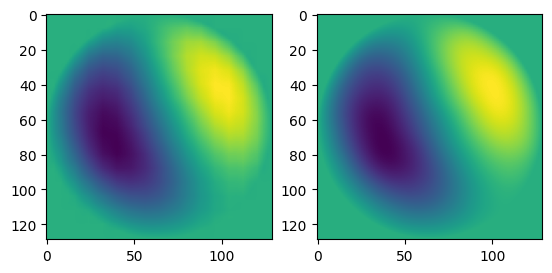

In [30]:
plt.subplot(121)
plt.imshow(uh_[0])
plt.subplot(122)
plt.imshow(uh[0])